INSTALLATION REFERENCES FOR LIGHTGBM WITH GPU

https://lightgbm.readthedocs.io/en/latest/GPU-Tutorial.html

https://medium.com/@am.sharma/lgbm-on-colab-with-gpu-c1c09e83f2af


In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 21480 (delta 2), reused 1 (delta 0), pack-reused 21467
Receiving objects: 100% (21480/21480), 16.87 MiB | 18.53 MiB/s, done.
Resolving deltas: 100% (15742/15742), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728       

In [ ]:
%cd /content/LightGBM

/content/LightGBM


In [ ]:
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [ ]:
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

Scanning dependencies of target _lightgbm
Scanning dependencies of target lightgbm
[  1%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/boosting.cpp.o
[  2%] Building CXX object CMakeFiles/lightgbm.dir/src/main.cpp.o
[  4%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/gbdt.cpp.o
[  5%] Building CXX object CMakeFiles/lightgbm.dir/src/application/application.cpp.o
[  7%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/gbdt_model_text.cpp.o
[  8%] Building CXX object CMakeFiles/lightgbm.dir/src/boosting/boosting.cpp.o
[ 10%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/gbdt_prediction.cpp.o
[ 11%] Building CXX object CMakeFiles/_lightgbm.dir/src/boosting/prediction_early_stop.cpp.o
[ 13%] Building CXX object CMakeFiles/_lightgbm.dir/src/io/bin.cpp.o
[ 14%] Building CXX object CMakeFiles/_lightgbm.dir/src/io/config.cpp.o
[ 15%] Building CXX object CMakeFiles/_lightgbm.dir/src/io/config_auto.cpp.o
[ 17%] Building CXX object CMakeFiles/_lightgb

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.7MB 63kB/s 


IMPORT LIBRARIES

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
import pickle
import pandas as pd
from scipy.stats import randint as sp_randint
import numpy as np
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

LOAD DATA

In [ ]:
data_train=pickle.load(open('/content/drive/MyDrive/instcart/DATA2/data_train.pkl','rb'))
data_test =pickle.load(open('/content/drive/MyDrive/instcart/DATA2/data_test.pkl','rb'))

In [ ]:
print(data_train.shape)
data_train.head()

(8474661, 78)


up_unique_orders_count  ...  reordered
user_id product_id                          ...           
1       196                             10  ...        1.0
        10258                            9  ...        1.0
        10326                            1  ...        0.0
        12427                           10  ...        0.0
        13032                            3  ...        1.0

[5 rows x 78 columns]

Distribution of class 0 and 1

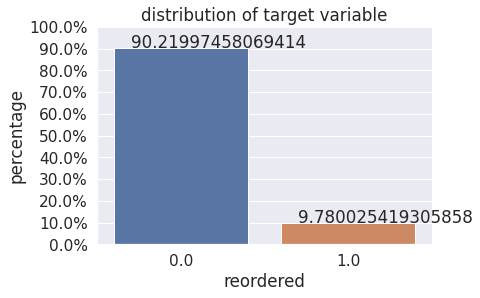

In [ ]:
sns.set(font_scale =1.4)
plt.figure(figsize=(6,4))
total = len(data_train)*1.
ax=sns.countplot(x='reordered',data=data_train)
for p in ax.patches:
        #for put value on countplot graph,In the simplest form, the text is placed at xy.
        ax.annotate((p.get_height()/total)*100, (p.get_x()+0.1, p.get_height()+5))
        
#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.title("distribution of target variable")
plt.ylabel("percentage")
plt.show()

Observation: Our target variable is highly imbalanced.

Define features and target variable

In [ ]:
data_train=data_train.drop(['eval_set', 'order_id'], axis=1)
data_test=data_test.drop(['eval_set', 'order_id'], axis=1)
print(data_train.shape,data_test.shape)

(8474661, 76) (4833292, 75)


In [ ]:
X = data_train.drop(['reordered'], axis=1)
y = data_train.reordered

In [ ]:
X.columns

Index(['up_unique_orders_count', 'up_total_buy_max', 'up_orders_diff',
       'up_order_ratio', 'up_mean_dow', 'up_mean_hod', 'up_mean_dsp',
       'up_sum_order_no', 'up_mean_cart', 'last_5_count', 'last_5_ratio',
       'chance_in_last_5', 'total_no_of_order_by_user', 'total_no_of_items',
       'total_no_of_unique_items', 'avg_product_in_order_by_user',
       'num_reorders_by_user', 'reordered_mean_user', 'user_dow_mean',
       'user_hod_mean', 'user_dsp_mean', 'user_max_order_day', 'user_max_hod',
       'total_unique_aisle_by_user', 'p_unique_users', 'p_total_purchase',
       'p_sum_reordered', 'p_mean_reordered', 'p_mean_dow', 'p_mean_hod',
       'p_mean_dsp', 'p_mean_cart', 'pca_product0', 'pca_product1',
       'pca_product2', 'pca_product3', 'pca_product4', 'pca_product5',
       'pca_product6', 'pca_product7', 'pca_product8', 'pca_product9',
       'pca_product10', 'pca_product11', 'pca_product12', 'pca_product13',
       'pca_product14', 'pca_product15', 'pca_product16',

In [ ]:
del data_train

Define train and cv data for model

In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, random_state=12)
print("train data:",X_train.shape , "y_train ",y_train.shape)
print("cv data from data_train: x_cv",X_cv.shape , "y_cv",y_cv.shape)

train data: (6779728, 75) y_train  (6779728,)
cv data from data_train: x_cv (1694933, 75) y_cv (1694933,)


In [ ]:
del X, y

## MODELING

HYPERPARAMETER TUNNING ON LGBM

In [ ]:
params={
     'learning_rate':[0.05,0.1,0.2],
     'n_estimators':sp_randint(400,1000),
     'max_depth': sp_randint(4,15),
     'class_weight':[{0:1,1:1},{0:1,1:3},{0:1,1:2}],
      }
lgbm=LGBMClassifier(device_type='gpu')
random_clf=RandomizedSearchCV(lgbm,params,n_iter=5,scoring='f1',verbose=5,return_train_score=True,cv=5)
random_clf.fit(X_train,y_train)
print(random_clf.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END class_weight={0: 1, 1: 3}, learning_rate=0.1, max_depth=12, n_estimators=539; total time= 1.9min
[CV 2/5] END class_weight={0: 1, 1: 3}, learning_rate=0.1, max_depth=12, n_estimators=539; total time= 1.8min
[CV 3/5] END class_weight={0: 1, 1: 3}, learning_rate=0.1, max_depth=12, n_estimators=539; total time= 1.9min
[CV 4/5] END class_weight={0: 1, 1: 3}, learning_rate=0.1, max_depth=12, n_estimators=539; total time= 1.9min
[CV 5/5] END class_weight={0: 1, 1: 3}, learning_rate=0.1, max_depth=12, n_estimators=539; total time= 1.9min
[CV 1/5] END class_weight={0: 1, 1: 2}, learning_rate=0.05, max_depth=4, n_estimators=844; total time= 2.8min
[CV 2/5] END class_weight={0: 1, 1: 2}, learning_rate=0.05, max_depth=4, n_estimators=844; total time= 2.8min
[CV 3/5] END class_weight={0: 1, 1: 2}, learning_rate=0.05, max_depth=4, n_estimators=844; total time= 2.9min
[CV 4/5] END class_weight={0: 1, 1: 2}, learning_rate=0.05, 

Make dataframe of result to select hyperparameter

In [ ]:
results = pd.DataFrame.from_dict(random_clf.cv_results_)

In [ ]:
print('mean test scores',random_clf.cv_results_['mean_test_score'])

mean test scores [0.44399206 0.40919874 0.41251135 0.29305328 0.40647356]


In [ ]:
results[['mean_train_score','mean_test_score','param_class_weight', 'param_learning_rate', 'param_max_depth','param_n_estimators']]

,mean_train_score,mean_test_score,param_class_weight,param_learning_rate,param_max_depth,param_n_estimators
0,0.449057,0.443992,"{0: 1, 1: 3}",0.1,12,539
1,0.411069,0.409199,"{0: 1, 1: 2}",0.05,4,844
2,0.415857,0.412511,"{0: 1, 1: 2}",0.05,12,698
3,0.303334,0.293053,"{0: 1, 1: 1}",0.1,7,921
4,0.407462,0.406474,"{0: 1, 1: 2}",0.05,4,430


Train lgbm on learning_rate=0.1, max_depth=12, n_estimators=539,class_weight={0: 1, 1: 3}

In [ ]:
lgb_clf_final_set2 = LGBMClassifier(learning_rate=0.1, max_depth=12,
               n_estimators=539,class_weight={0: 1, 1: 3}	)

lgb_clf_final_set2.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 3},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=12, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=539, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

Select threshold for LGBM


In [ ]:
def threshold_vs_score(X_cv,y_cv,model):
  f1_scores_threshold = []
  threshold=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
  for i in threshold:
      y_cv_hat = (model.predict_proba(X_cv)[:, 1] >= i).astype('int')
      score=f1_score(y_cv , y_cv_hat)
      f1_scores_threshold.append(score)  
  return threshold, f1_scores_threshold 

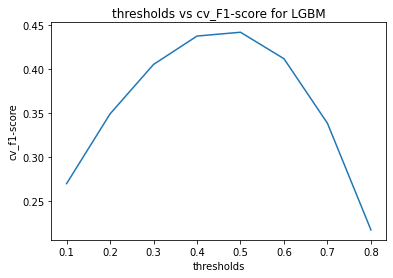

In [ ]:
threshold, f1_scores_threshold =threshold_vs_score(X_cv,y_cv,lgb_clf_final_set2)
plt.plot(threshold, f1_scores_threshold )
plt.xlabel("thresholds")
plt.ylabel("cv_f1-score")
plt.title("thresholds vs cv_F1-score for LGBM")
plt.show()

Best thresholds for lGBM  is   0.51 for class_weight={0: 1, 1: 3}  

In [ ]:
y_hat =(lgb_clf_final_set2.predict_proba(X_train)[:, 1] >= 0.51).astype('int')
y_cv_hat = (lgb_clf_final_set2.predict_proba(X_cv)[:, 1] >= 0.51).astype('int')
print("training F1-score for lgbm:", f1_score(y_train , y_hat))
print("cv F1-score for lgbm:",f1_score(y_cv , y_cv_hat))

training F1-score for lgbm: 0.4472718462886002
cv F1-score for lgbm: 0.4431174197863358


save model lgb_clf_final_set2

In [ ]:
pickle.dump((lgb_clf_final_set2),open('/content/drive/MyDrive/instcart/DATA2/lgb_clf_final_set2','wb'))

CATBOOST CLASSIFIER

In [ ]:
params_cat={
     'learning_rate':[0.001,0.01,0.1,1],
     'depth': sp_randint(5,14),
     'iterations':sp_randint(400,1200),
     'bagging_temperature':[0.1,0.2,0.3,0.5,0.8,0.9]
     }
cat=CatBoostClassifier(task_type='GPU')
random_cat=RandomizedSearchCV(cat, param_distributions=params_cat ,n_iter=6,cv=5,scoring='f1',
                             random_state=11,return_train_score=True)
random_cat.fit(X_train,list(map(int , y_train)))

Streaming output truncated to the last 5000 lines.
158:	learn: 0.2300188	total: 13.1s	remaining: 1m 1s
159:	learn: 0.2299401	total: 13.2s	remaining: 1m 1s
160:	learn: 0.2298481	total: 13.3s	remaining: 1m 1s
161:	learn: 0.2297660	total: 13.4s	remaining: 1m 1s
162:	learn: 0.2296959	total: 13.5s	remaining: 1m
163:	learn: 0.2296062	total: 13.5s	remaining: 1m
164:	learn: 0.2295289	total: 13.6s	remaining: 1m
165:	learn: 0.2294486	total: 13.7s	remaining: 1m
166:	learn: 0.2293458	total: 13.8s	remaining: 1m
167:	learn: 0.2292491	total: 13.9s	remaining: 1m
168:	learn: 0.2291472	total: 14s	remaining: 1m
169:	learn: 0.2290560	total: 14s	remaining: 1m
170:	learn: 0.2289588	total: 14.1s	remaining: 1m
171:	learn: 0.2288679	total: 14.2s	remaining: 1m
172:	learn: 0.2287714	total: 14.3s	remaining: 1m
173:	learn: 0.2287008	total: 14.4s	remaining: 1m
174:	learn: 0.2286275	total: 14.5s	remaining: 60s
175:	learn: 0.2285575	total: 14.5s	remaining: 59.9s
176:	learn: 0.2284707	total: 14.6s	remaining: 59.8s
177

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fb16a43f6d8>,
                   iid='deprecated', n_iter=6, n_jobs=None,
                   param_distributions={'bagging_temperature': [0.1, 0.2, 0.3,
                                                                0.5, 0.8, 0.9],
                                        'depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb16a43f710>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb16a43f860>,
                                        'learning_rate': [0.001, 0.01, 0.1, 1]},
                   pre_dispatch='2*n_jobs', random_state=11, refit=True,
                   return_train_score=True, scoring='f1', verbose=0)

In [ ]:
print('mean test scores',random_cat.cv_results_['mean_test_score'])

mean test scores [0.26387393 0.29182628 0.24663616 0.25986796 0.32199707 0.25429077]


Make dataframe of result to select hyperparameter

In [ ]:
results_cat = pd.DataFrame.from_dict(random_cat.cv_results_)

In [ ]:
results_cat[['mean_train_score','mean_test_score', 'param_learning_rate', 'param_depth','param_iterations','param_bagging_temperature']]

,mean_train_score,mean_test_score,param_learning_rate,param_depth,param_iterations,param_bagging_temperature
0,0.264087,0.263874,0.01,5,491,0.2
1,0.297868,0.291826,0.1,6,983,0.9
2,0.246863,0.246636,0.001,5,1165,0.1
3,0.260149,0.259868,0.001,9,946,0.9
4,0.603219,0.321997,1,10,901,0.2
5,0.254268,0.254291,0.001,6,491,0.8


Train catboost classfier on  best parameter iterations = 983,
                            depth = 6,
                            learning_rate=0.1,
                            bagging_temperature=0.9

In [ ]:
cat_clf_set2 = CatBoostClassifier(
                            iterations = 983,
                            depth = 6,
                            learning_rate=0.1,
                            verbose = 5,
                            bagging_temperature=0.9)

cat_clf_set2.fit(X_train, list(map(int , y_train)))

0:	learn: 0.5861807	total: 1.81s	remaining: 29m 34s
5:	learn: 0.3383428	total: 10.4s	remaining: 28m 14s
10:	learn: 0.2795086	total: 19s	remaining: 27m 54s
15:	learn: 0.2599460	total: 27.9s	remaining: 28m 6s
20:	learn: 0.2537321	total: 36.6s	remaining: 27m 56s
25:	learn: 0.2512010	total: 45.8s	remaining: 28m 5s
30:	learn: 0.2498025	total: 55s	remaining: 28m 8s
35:	learn: 0.2491211	total: 1m 3s	remaining: 28m 1s
40:	learn: 0.2486477	total: 1m 13s	remaining: 28m 1s
45:	learn: 0.2483575	total: 1m 21s	remaining: 27m 37s
50:	learn: 0.2481180	total: 1m 29s	remaining: 27m 23s
55:	learn: 0.2478776	total: 1m 39s	remaining: 27m 22s
60:	learn: 0.2476850	total: 1m 48s	remaining: 27m 20s
65:	learn: 0.2475193	total: 1m 57s	remaining: 27m 15s
70:	learn: 0.2473781	total: 2m 6s	remaining: 27m 7s
75:	learn: 0.2471239	total: 2m 15s	remaining: 26m 54s
80:	learn: 0.2469905	total: 2m 24s	remaining: 26m 48s
85:	learn: 0.2467570	total: 2m 33s	remaining: 26m 35s
90:	learn: 0.2466604	total: 2m 42s	remaining: 26m

select threshold for  catboost classifier

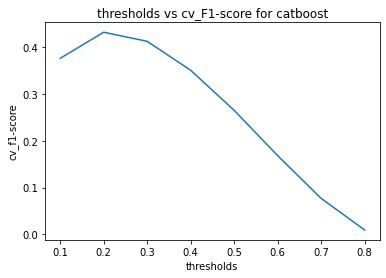

In [ ]:
threshold, f1_scores_threshold =threshold_vs_score(X_cv,list(map(int,y_cv)),cat_clf_set2)
plt.plot(threshold, f1_scores_threshold )
plt.xlabel("thresholds")
plt.ylabel("cv_f1-score")
plt.title("thresholds vs cv_F1-score for catboost")
plt.show()

Best thresholds for catboost classifier  is 0.21

In [ ]:
y_hat =(cat_clf_set2.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
y_cv_hat = (cat_clf_set2.predict_proba(X_cv)[:, 1] >= 0.21).astype('int')
print("training F1-score for catboost:", f1_score(y_train , y_hat))
print("cv F1-score for catboost:",f1_score(y_cv , y_cv_hat))

training F1-score for catboost: 0.44980562794708
cv F1-score for catboost: 0.44631628100031134


save model cat_clf_set2

In [ ]:
pickle.dump((cat_clf_set2),open("/content/drive/MyDrive/instcart/DATA2/cat_clf_set2",'wb'))

SUBMISSION

reference : https://www.kaggle.com/errolpereira/light-gradient-boosting

In [ ]:
orders=pd.read_csv("/content/drive/MyDrive/instcart/six file/orders.csv")

In [ ]:
# x is data  on which we perform prediction
# y_hat is prediction generated on x
# This function takes input data,orders,prediction as input and return dataframe which contain order_id and product_ids for test data 
def generate_submission(x,orders,y_hat):
  result = x.copy()
  result['prediction'] =y_hat
  result = result.reset_index() 
  result = result[['product_id', 'user_id', 'prediction']]
  orders_in_test = orders.loc[orders['eval_set']=='test',['user_id','order_id']]

  output_results = pd.merge(result, orders_in_test, how='left', on='user_id')
  output_results  =  output_results.drop('user_id',axis=1)
  
  # output_results contains order_id,product_id,prediction
  # generate submission format which has order_id and product_id 
  
  d = dict()   
  # d contains order_id as key and values are predicted product_ids
  for row in output_results.itertuples():
      if row.prediction== 1:
          try:
              d[row.order_id] += ' ' + str(row.product_id)
          except:
              d[row.order_id] = str(row.product_id)

  for order in output_results.order_id:
      if order not in d:
          d[order] = 'None'

  sub_csv = pd.DataFrame.from_dict(d, orient='index')
  #Specify orient='index' to create the DataFrame using dictionary keys as rows
  #Reset index
  sub_csv.reset_index(inplace=True)
  #Set column names
  sub_csv.columns = ['order_id', 'products']
  return  sub_csv

submission for lgb_clf_final_set2

In [ ]:
y_test_hat_lgbm_set2=(lgb_clf_final_set2.predict_proba(data_test)[:, 1] >= 0.51).astype('int')
lgbm_submission_set2=generate_submission(data_test,orders,y_test_hat_lgbm_set2)
lgbm_submission_set2.head()

,order_id,products
0,2774568,17668 18599 21903 23650 39190 43961 47766
1,1528013,21903 38293
2,1376945,8309 13176 14947 27959 28465 33572 34658 44632
3,1356845,7076 10863 13176 14992
4,2161313,196 10441 12427 14715 27839 37710


In [ ]:
lgbm_submission_set2.to_csv('/content/drive/MyDrive/instcart/DATA2/lgbm_submission_set2',index=False)

submission on cat_clf_set2 

In [ ]:
y_test_hat_cat_clf_set2 =(cat_clf_set2.predict_proba(data_test)[:, 1] >= 0.21).astype('int')
submission_cat_clf_set2 =generate_submission(data_test,orders,y_test_hat_cat_clf_set2)
submission_cat_clf_set2.head()

,order_id,products
0,2774568,17668 18599 21903 23650 24810 39190 43961 47766
1,1528013,8424 21903 38293
2,1376945,8309 13176 14947 24799 27959 28465 33572 34658...
3,1356845,7076 10863 11520 13176 14992 22959 28134
4,2161313,196 10441 11266 12427 14715 27839 37710


In [ ]:
submission_cat_clf_set2.to_csv('/content/drive/MyDrive/instcart/DATA2/submission_cat_clf_set2',index=False)

Results


In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Train F1 Score", "cv F1 Score", 'kaggle Private Score','kaggle Public Score']
table.add_row(["Light GBM set2", 0.4472718462886002, 0.4431174197863358,'Nan','Nan'])
table.add_row(['catboost set2',0.44980562794708,  0.44631628100031134,0.38338,0.38427])
print(table) 

+----------------+--------------------+---------------------+----------------------+---------------------+
|     Model      |   Train F1 Score   |     cv F1 Score     | kaggle Private Score | kaggle Public Score |
+----------------+--------------------+---------------------+----------------------+---------------------+
| Light GBM set2 | 0.4472718462886002 |  0.4431174197863358 |         Nan          |         Nan         |
| catboost set2  |  0.44980562794708  | 0.44631628100031134 |       0.38338        |       0.38427       |
+----------------+--------------------+---------------------+----------------------+---------------------+


Submission on kaggle for catboost classifier

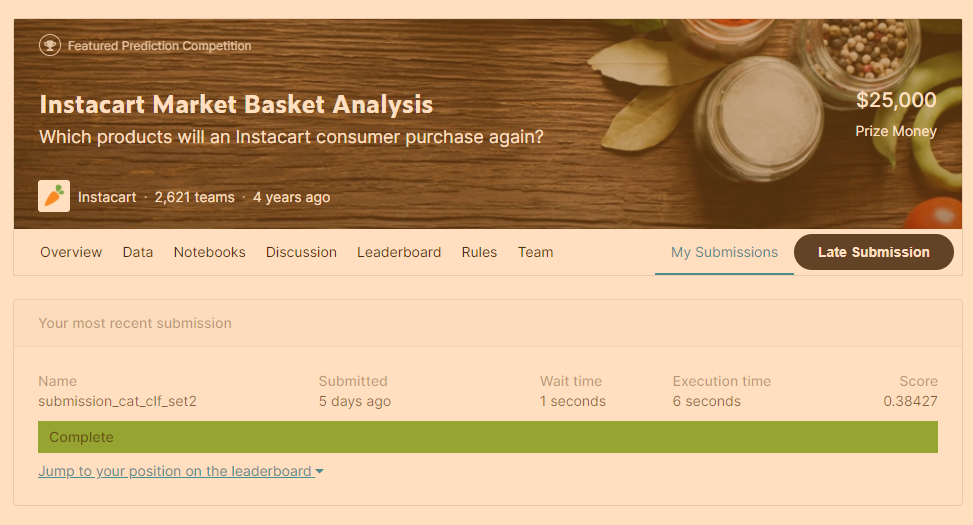

In [3]:
from PIL import Image
img = Image.open("instacart-sub.PNG")
img

create output csv file  on data_train  for catboost classifier 

In [ ]:
cat_clf_set2=pickle.load(open("/content/drive/MyDrive/instcart/DATA2/cat_clf_set2",'rb'))

In [ ]:
data_train=pickle.load(open('/content/drive/MyDrive/instcart/DATA2/data_train.pkl','rb'))

In [ ]:
print(data_train.shape)
data_train.head()

(8474661, 78)


up_unique_orders_count  ...  reordered
user_id product_id                          ...           
1       196                             10  ...        1.0
        10258                            9  ...        1.0
        10326                            1  ...        0.0
        12427                           10  ...        0.0
        13032                            3  ...        1.0

[5 rows x 78 columns]

In [ ]:
# x is data  on which we perform prediction
# y_hat is prediction generated on x
# This function takes input data,orders,prediction as input and return dataframe which contain order_id and product_ids for test data 
def generate_prediction_on_data_train(x,orders,y_hat):
  result = x.copy()
  result['prediction'] =y_hat
  result = result.reset_index() 
  output_results  = result[['product_id', 'prediction','order_id']]

  # output_results contains order_id,product_id,prediction
  #  set format which has order_id and product_id 
  
  d = dict()   
  # d contains order_id as key and values are predicted product_ids
  for row in output_results.itertuples():
      if row.prediction== 1:
          try:
              d[row.order_id] += ' ' + str(row.product_id)
          except:
              d[row.order_id] = str(row.product_id)

  for order in output_results.order_id:
      if order not in d:
          d[order] = 'None'

  sub_csv = pd.DataFrame.from_dict(d, orient='index')
  #Specify orient='index' to create the DataFrame using dictionary keys as rows
  #Reset index
  sub_csv.reset_index(inplace=True)
  #Set column names
  sub_csv.columns = ['order_id', 'products']
  return  sub_csv

In [ ]:
y_train_hat_cat_clf_set2 =(cat_clf_set2.predict_proba(data_train.drop(['eval_set', 'order_id','reordered'],axis=1))[:, 1] >= 0.21).astype('int')
data_train_output_cat_clf_set2 =generate_prediction_on_data_train(data_train,orders,y_train_hat_cat_clf_set2)
data_train_output_cat_clf_set2.head()

,order_id,products
0,1187899,196 10258 12427 13032 25133 35951 38928 39657 ...
1,1492625,1559 16589 18523 19156 21709 24852 32792 33754...
2,2196797,8518 11777 21413 24535 26604 27344 40706 43693
3,525192,4920 4945 9598 13198 15592 17638 21137 27690 3...
4,880375,2078 4799 9839 17794 18531 21903 23165 28985 3...


merge data_train and data_test csv file output


In [ ]:
submission_cat_clf_set2=pd.read_csv('/content/drive/MyDrive/instcart/DATA2/submission_cat_clf_set2')
submission_cat_clf_set2.head()

,order_id,products
0,2774568,17668 18599 21903 23650 24810 39190 43961 47766
1,1528013,8424 21903 38293
2,1376945,8309 13176 14947 24799 27959 28465 33572 34658...
3,1356845,7076 10863 11520 13176 14992 22959 28134
4,2161313,196 10441 11266 12427 14715 27839 37710


In [ ]:
print(data_train_output_cat_clf_set2.shape,submission_cat_clf_set2.shape)

(131209, 2) (75000, 2)


In [ ]:
output_train_test=pd.concat([data_train_output_cat_clf_set2,submission_cat_clf_set2])
print(output_train_test.shape)
output_train_test.head()

(206209, 2)


,order_id,products
0,1187899,196 10258 12427 13032 25133 35951 38928 39657 ...
1,1492625,1559 16589 18523 19156 21709 24852 32792 33754...
2,2196797,8518 11777 21413 24535 26604 27344 40706 43693
3,525192,4920 4945 9598 13198 15592 17638 21137 27690 3...
4,880375,2078 4799 9839 17794 18531 21903 23165 28985 3...


In [ ]:
output_train_test.to_csv('/content/drive/MyDrive/instcart/DATA2/output_train_test.csv',index=False)